<a href="https://colab.research.google.com/github/shehanshaman/fyp_short_sem/blob/master/Feature_selection_in_brain_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [193]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Features 2313 | GSE5281**

In [194]:
import numpy as np
import pandas as pd

df = pd.read_pickle("drive/My Drive/FYP/dataset/GSE5281/GSE5281_DE_2311.plk")
df.head()

Symbol,AARS,AARSD1,AASDHPPT,ABHD10,ABHD14A,ABL1,ABRACL,AC004951.6,ACACB,ACAD11,ACAT2,ACBD5,ACBD6,ACKR3,ACO2,ACOT1,ACOT13,ACOT2,ACOT7,ACP1,ACP2,ACSS3,ACTB,ACTG1,ACTL6B,ACTR10,ACTR1A,ACTR1B,ACTR3B,ACVR1C,ACYP1,ACYP2,ADAM23,ADAM33,ADCYAP1,ADD3,ADORA2A,ADSL,AEBP1,AF086102,...,ZCCHC24,ZDHHC23,ZDHHC6,ZFAND1,ZFAND2A,ZFPM2,ZHX2,ZIC2,ZMAT2,ZMAT4,ZNF184,ZNF204P,ZNF211,ZNF222,ZNF239,ZNF266,ZNF285,ZNF32,ZNF34,ZNF365,ZNF385D,ZNF415,ZNF423,ZNF510,ZNF540,ZNF57,ZNF593,ZNF615,ZNF622,ZNF667-AS1,ZNF721,ZNF768,ZNF806,ZNHIT1,ZNHIT3,ZNRF3,ZSCAN29,ZUFSP,ZWINT,class
GSM119615,7.345998,5.457888,6.457715,5.222908,6.995749,6.697207,5.319977,4.923159,5.472710,7.131173,5.600223,5.979178,5.085105,4.153222,5.972764,4.937233,5.534014,4.937233,6.514569,5.155803,6.237769,3.901946,10.345539,11.402404,6.115036,9.147185,5.617101,6.120119,6.102143,5.930150,7.605712,6.638414,5.792860,5.133966,4.706358,8.755479,5.030628,6.390630,5.053709,3.886501,...,7.456909,5.669100,6.919348,6.348267,6.485093,5.305242,4.921659,5.868591,6.956969,5.694688,7.567398,7.275703,6.995754,4.488878,4.592465,6.506459,6.471996,5.895299,4.926363,6.730293,5.570735,5.994068,6.634812,3.541078,5.552222,3.514189,4.718988,6.326958,5.569774,7.300851,8.629087,4.735291,6.471996,5.681661,6.361654,6.865166,5.589593,4.738170,5.513848,0
GSM119616,7.558251,5.637492,6.036189,5.330163,8.230362,5.817864,4.530317,4.308553,5.009336,5.811417,5.085261,5.975618,5.604409,3.261599,5.654553,4.135804,4.744815,4.135804,6.618332,4.567018,6.806159,3.376471,10.282250,11.045969,7.416912,8.091208,7.317110,6.530682,5.476064,4.304923,6.258544,5.897651,5.512367,4.747103,4.560740,7.625679,4.953816,6.240699,4.490073,4.828913,...,7.418142,4.839082,6.752301,5.773107,6.662340,5.468695,5.146795,4.223862,7.573742,4.771866,6.276483,6.709932,6.335288,3.801299,6.630902,6.694868,6.960609,6.099886,5.236059,5.642705,5.489166,6.231582,5.779639,3.747980,5.643610,4.072797,5.682292,6.188917,5.932576,8.169157,8.470548,4.956140,6.960609,6.217973,4.628300,5.501946,4.660760,4.430194,7.098218,0
GSM119617,7.779243,5.169164,4.071870,4.845279,7.272655,4.758254,3.442644,5.665046,5.303650,4.871424,4.629077,5.377692,4.427671,3.313318,5.328443,3.653694,4.861480,3.653694,6.065900,3.786201,5.229597,3.894953,8.481655,8.797133,5.567347,5.903681,5.771940,6.540733,4.187711,3.556930,3.162175,4.508419,4.206409,5.542687,3.680112,7.459279,4.883552,5.058969,5.182578,3.970806,...,7.630651,4.161917,5.604465,4.249456,4.288658,3.029275,5.561144,4.741784,5.538280,4.556024,4.980260,4.544694,5.515129,4.506145,5.424791,5.797022,5.131703,5.301019,5.756921,4.695887,5.174808,4.269931,4.718790,3.110427,4.908485,3.417229,4.716958,5.135190,5.038118,7.399993,7.720850,5.424746,5.131703,5.675858,3.967635,5.374681,3.809305,3.575631,5.042132,0
GSM119618,7.810550,5.485270,4.304090,4.821332,7.778957,4.805781,3.571033,5.699413,5.618037,5.449554,4.946705,5.452644,4.874938,3.306646,5.443538,3.364116,4.881130,3.364116,6.330254,4.077172,5.621003,3.712081,8.646504,8.886968,6.314471,5.887549,6.125098,7.052538,4.252690,3.650720,3.572474,4.551315,4.324177,5.627620,3.665845,7.633911,4.752503,5.630734,5.389899,3.932995,...,7.807734,4.388038,5.327865,4.679722,4.750181,3.387178,5.802164,4.456430,5.658085,4.293989,5.371010,4.304102,5.232679,3.894932,5.629742,6.403059,5.771122,5.704184,6.495187,4.787603,5.489591,5.016427,5.364951,3.495104,5.163635,4.061560,4.903658,5.400820,5.328021,6.945329,7.838050,5.404067,5.771122,5.932593,3.883264,5.608697,4.211155,3.778329,5.602894,0
GSM119619,8.074834,5.911958,6.958319,6.255834,6.994396,6.369175,7.112512,3.590518,4.652429,6.769900,6.201822,6.749242,5.504370,3.531554,5.775032,5.162592,6.193117,5.162592,7.269916,5.496397,6.184694,3.692820,10.904771,12.221906,6.720066,9.902034,6.669995,6.765127,6.751892,5.324161,8.689820,7.127657,5.899349,4.397827,6.025239,8.267712,5.103160,7.237664,4.329696,3.932912,...,6.909034,6.808954,7.671105,6.183350,7.541058,6.393106,4.893038,4.778356,7.465149,6.396728,8.260375,7.200142,6.764953,5.059041,5.900729,7.771480,6.948112,7.117101,4

**Features 200 | Univeriate Selection**

In [0]:
X = df.drop("class",1)   #Feature Matrix
y = df["class"]          #Target Variable

In [196]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# print(featureScores.nlargest(2000,'Score'))  #print 10 best features
selectedFeatures = featureScores.nlargest(200,'Score')

pd.options.mode.chained_assignment = None

df_200F = df[selectedFeatures['Specs'].values]
df_200F['class'] = y
df_200F.head()

Symbol,SST,CHGB,CALY,CHRM1,GOT1,STAT4,NME1,AC004951.6,AX747182,SERTM1,PCSK1,ATP6V1G2,MT1M,GPI,LOC101929787,LOC100272216,MAFF,KIFAP3,MAL2,AMPH,SLC39A12,MTX2,MIR612,NEAT1,ZIC2,PCYOX1L,TAC1,ZNF204P,JPX,MDH1,CCK,PSMB3,NIT2,ATP5B,TMEM200A,ATP6V1B2,DHCR24,SLIRP,VSNL1,MGC12488,...,TM9SF2,CCNH,SLC12A7,APLNR,MAP2K1,SLC35B1,CACNA2D3,PCDH8,GLRB,NEFL,YAP1,NRSN1,SLC9A6,CAPNS1,ALAS1,FIG4,PSENEN,GFAP,IMMT,SUCLA2,FHL2,AK090844,RAB33A,ZCCHC24,PPEF1,MLLT11,RGS4,SLC16A14,SNCA,PRR34-AS1,RGS7,NRXN3,NAA20,UCHL3,HACL1,ATP6V0B,ATP1A1,SLITRK4,MAP7D2,class
GSM119615,8.131880,8.038977,5.151241,5.960189,6.496582,5.177266,6.735126,4.923159,4.923159,5.585295,5.573235,8.434417,3.951437,6.968975,5.885994,6.083629,4.681431,6.380428,8.110305,8.915695,6.329852,7.560527,5.166372,5.166372,5.868591,6.328347,8.347192,7.275703,2.934900,10.763783,9.171231,6.893028,6.257113,8.455516,7.526488,8.284930,6.960068,7.639021,10.283798,4.911598,...,6.481914,7.011247,6.635072,4.528372,8.128725,5.278402,7.828262,9.860453,6.917989,9.267750,4.186140,8.675869,9.841581,6.251841,5.816591,7.935832,4.435020,7.054613,7.414872,7.961066,5.799641,5.298147,5.783877,7.456909,3.927690,10.847098,7.307455,8.620085,7.958731,6.325037,6.384926,7.623302,7.276087,5.246386,4.698036,6.566670,8.079477,7.012174,8.392132,0
GSM119616,9.505370,6.843639,5.565685,8.256848,6.808876,5.937782,7.084662,4.308553,4.308553,5.424460,4.320161,8.430603,4.281796,8.000928,5.867583,5.881952,4.849331,4.707004,6.259058,8.320264,3.686194,6.720044,4.380328,4.380328,4.223862,7.514385,5.181012,6.709932,2.920651,9.269761,7.808680,8.121838,6.331245,8.937122,8.268992,7.795785,7.118234,8.470085,9.097778,4.862214,...,5.992824,6.292830,6.375591,5.458683,7.259421,6.062100,7.621714,8.018103,6.181431,8.943403,3.566653,7.639978,9.082520,7.135552,6.144733,9.000454,4.363489,7.491630,6.946851,7.412511,6.767040,5.279988,6.146401,7.418142,5.079694,11.668155,7.324564,7.498362,7.426317,6.648298,6.447447,6.868568,6.718846,4.696639,5.302263,6.957373,8.561748,6.600915,8.290398,0
GSM119617,5.369160,4.665645,4.252331,6.834361,4.808397,4.486761,5.409682,5.665046,5.665046,3.364531,3.173762,5.653338,5.513703,6.178967,4.493120,6.389841,4.266874,3.454873,3.314502,5.044705,3.599311,4.476322,4.598128,4.598128,4.741784,5.884224,2.750926,4.544694,2.957573,6.592042,5.094963,5.935664,3.925424,7.702212,4.875246,5.456936,4.877980,6.446468,6.502673,5.294911,...,4.393931,4.383398,6.730196,5.016607,5.234606,4.735439,4.595901,4.923356,4.103622,5.937121,3.534403,6.366537,6.387074,6.485473,4.318861,8.097815,3.472717,7.186470,5.193497,4.871446,5.890325,6.716955,4.677529,7.630651,3.765344,9.503726,5.363508,4.069276,5.191100,6.747926,5.840032,5.171308,4.926782,3.523475,3.793645,5.613994,6.183599,3.677790,6.366832,0
GSM119618,5.999060,5.293017,5.245800,7.863578,4.886358,4.517919,4.878878,5.699413,5.699413,3.256316,3.239969,6.032224,5.696868,6.902142,4.852395,6.174321,4.890228,3.162665,3.420588,6.075690,3.675883,5.037034,4.777270,4.777270,4.456430,6.072395,3.954933,4.304102,3.929218,6.965705,5.701809,6.574085,4.373662,7.954236,4.715554,5.423112,5.092454,6.445284,7.277838,5.940631,...,4.946065,4.509396,6.818696,5.455425,4.170590,4.704986,4.562267,5.021351,4.262546,6.659974,3.333360,6.384433,7.335424,6.555934,4.342724,8.521468,3.992268,7.553568,5.467763,4.919411,5.698300,6.608849,5.180804,7.807734,3.603359,10.139533,5.626352,4.978548,6.106691,7.378966,5.936174,5.411828,5.461794,3.848761,4.159845,6.010982,6.505356,4.053398,7.139060,0
GSM119619,9.820469,9.230820,6.719501,7.177746,7.966393,6.153760,8.338353,3.590518,3.590518,6.930045,6.690597,8.947760,4.743912,8.350846,5.228459,6.785353,5.220601,7.127253,9.211837,9.256675,5.360266,7.971362,4.845992,4.845992,4.778356,6.846255,9.312080,7.200142,3.003917,11.759778,9.423194,7.365393,7.489957,9.778586,8.368750,10.092938,8.010270,8.065691,10.858154,4.673697,...,8.024168,7.967964,5.854620,4.936726,8.956529,6.474409,8.466506,9.983657,7.696830,10.167188,4.075549,8.777251,9.862478,7.814851,7.751669,8.701667,5.069903,6.793184,7.869865,8

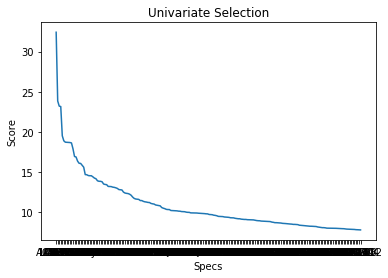

In [197]:
import matplotlib.pyplot as plt

plt.plot(  selectedFeatures["Specs"], selectedFeatures["Score"], label='linear')

plt.xlabel('Specs')
plt.ylabel('Score')
plt.title('Univariate Selection')
plt.show()

**Features 50 | PCA, RF, FI**

**PCA**

In [0]:
from sklearn import preprocessing

def dfToNorm(dataFrame):
  # Scaling features to a range [0,1]
  min_max_scaler = preprocessing.MinMaxScaler(feature_range=(1, 2))
  X_minmax = min_max_scaler.fit_transform(dataFrame)

  X_scaled = pd.DataFrame(X_minmax, columns = dataFrame.columns, index = dataFrame.index)
  return X_scaled
  
  

In [199]:
from sklearn.decomposition import PCA

X = df_200F.iloc[:,0:200].values
initial_feature_names = df_200F.columns[0:200].values

# 160 samples with 2312 features
train_features = X

model = PCA(n_components=63).fit(train_features)
X_pc = model.transform(train_features)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

#print(most_important_names)
#print(df[most_important_names]) 

#df[most_important_names].to_pickle('drive/My Drive/FYP/dataset/GSE5281/GSE5281_PCA_160.plk')
#print(most_important)

df_50F_PCA = df[most_important_names]
df_50F_PCA = df_50F_PCA.T.drop_duplicates().T
df_50F_PCA.head()
#len( df_50F.columns.unique())

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(df_50F_PCA,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df_50F_PCA.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# print(featureScores.nlargest(2000,'Score'))  #print 10 best features
selectedFeatures = featureScores.nlargest(50,'Score')

pd.options.mode.chained_assignment = None

df_50F_PCA = df[selectedFeatures['Specs'].values]
df_50F_PCA.head()

df_50F_PCA_Norm = round(dfToNorm(df_50F_PCA),2)
df_50F_PCA_Norm.head()

Symbol,SST,CHGB,STAT4,AC004951.6,PCSK1,LOC101929787,MAFF,AMPH,SLC39A12,ZIC2,PCYOX1L,TAC1,JPX,TMEM200A,SLIRP,SLC39A10,SPHKAP,CALB1,CDK7,AP2M1,LOC100507557,CTD-3092A11.2,PLK2,P2RY14,RP11-271C24.3,EMX2,SERPINF1,ARPC1A,PVALB,LOC101060510,PRO1804,VAMP7,LSM7,ATP1A3,PCP4,EXOC8,RIT2,BCAS1,PSMB4,LAMP5,APLNR,PCDH8,NRSN1,CAPNS1,ALAS1,FIG4,RAB33A,SLC16A14,PRR34-AS1,HACL1
GSM119615,1.68,1.54,1.37,1.42,1.46,1.47,1.27,1.63,1.59,1.37,1.60,1.74,1.11,1.78,1.65,1.99,1.61,1.84,1.75,1.61,1.64,1.68,1.70,1.10,1.66,1.52,1.39,1.39,1.10,1.27,1.12,1.77,1.38,1.47,1.02,1.73,1.20,1.16,1.48,1.74,1.23,1.90,1.96,1.43,1.52,1.64,1.35,1.84,1.42,1.40
GSM119616,1.86,1.40,1.50,1.31,1.26,1.47,1.30,1.55,1.17,1.14,1.82,1.35,1.11,1.89,1.78,1.67,1.84,1.37,1.65,1.93,1.41,1.45,1.61,1.13,1.44,1.35,1.45,1.54,1.08,1.32,1.20,1.83,1.51,1.67,1.70,1.58,1.57,1.18,1.46,1.47,1.37,1.66,1.79,1.62,1.59,1.80,1.43,1.65,1.48,1.55
GSM119617,1.31,1.15,1.25,1.55,1.08,1.26,1.19,1.11,1.16,1.21,1.51,1.04,1.12,1.37,1.47,1.12,1.56,1.09,1.14,1.53,1.24,1.12,1.10,1.09,1.30,1.26,1.37,1.30,1.23,1.55,1.22,1.28,1.42,1.43,1.33,1.08,1.37,1.22,1.08,1.28,1.31,1.24,1.58,1.48,1.20,1.66,1.13,1.07,1.50,1.16
GSM119618,1.40,1.22,1.25,1.56,1.09,1.31,1.31,1.25,1.17,1.17,1.55,1.19,1.34,1.34,1.47,1.20,1.56,1.18,1.19,1.62,1.33,1.29,1.16,1.17,1.21,1.31,1.47,1.20,1.21,1.49,1.26,1.39,1.52,1.41,1.30,1.14,1.39,1.24,1.21,1.42,1.37,1.26,1.58,1.49,1.21,1.73,1.23,1.22,1.61,1.26
GSM119619,1.90,1.68,1.54,1.18,1.64,1.37,1.36,1.68,1.44,1.22,1.69,1.86,1.13,1.91,1.72,1.92,1.85,1.80,1.82,1.80,1.50,1.53,1.85,1.11,1.78,1.38,1.73,1.62,1.05,1.37,1.30,1.91,1.68,1.56,1.55,1.85,1.78,1.36,1.71,1.68,1.29,1.92,1.98,1.76,1.93,1.75,1.77,1.91,1.41,1.62


**Random Forest**

In [0]:
from sklearn.ensemble import RandomForestClassifier

X = df_200F.drop("class",1)
y = df["class"]          #Target Variable

model = RandomForestClassifier(n_estimators=10000, random_state=42, n_jobs=-1)
model.fit(X,y)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

rf_selected = feat_importances.nlargest(50)

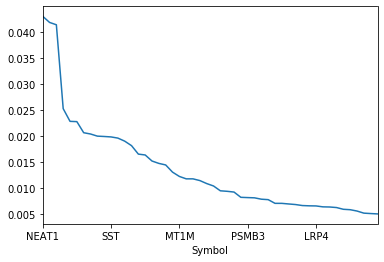

In [201]:
rf_selected.plot()

In [202]:
df_50F_RF = df[pd.DataFrame(rf_selected).T.columns]

df_50F_RF_Norm = dfToNorm(df_50F_RF)
df_50F_RF_Norm.head()

df_50F_RF_Norm = round(dfToNorm(df_50F_RF),2)
df_50F_RF_Norm.head()

Symbol,NEAT1,MIR612,PCYOX1L,CTD-3092A11.2,SLC12A7,FIBP,MLLT11,CKMT1B,JPX,GNG3,SST,CKMT1A,NIT2,ATP6V1E1,MAFF,MGC12488,LDHA,FIG4,LOC101929787,LOC202181,MT1M,ATP6V1G2,ATP5B,TUBB4B,LOC100272216,REEP1,CHRM1,COPG2IT1,TUBB3,AK090844,PSMB3,PRO1804,MIF,MKKS,GFAP,RGS7,CDK5,IMMT,PSMA5,PLSCR4,LRP4,BSCL2,PRR34-AS1,RP11-271C24.3,GPI,DDIT4,SLC39A12,YAP1,ATP5C1,AC004951.6
GSM119615,1.27,1.27,1.60,1.68,1.51,1.56,1.77,1.63,1.11,1.49,1.68,1.63,1.63,1.53,1.27,1.42,1.73,1.64,1.47,1.60,1.20,1.71,1.56,1.61,1.41,1.83,1.43,1.78,1.62,1.57,1.56,1.12,1.52,1.59,1.50,1.62,1.58,1.77,1.64,1.75,1.44,1.57,1.42,1.66,1.55,1.41,1.59,1.27,1.74,1.42
GSM119616,1.09,1.09,1.82,1.45,1.46,1.76,1.90,1.73,1.11,1.83,1.86,1.73,1.65,1.60,1.30,1.41,1.85,1.80,1.47,1.50,1.26,1.71,1.63,1.83,1.38,1.87,1.75,1.82,1.81,1.57,1.79,1.20,1.78,1.63,1.57,1.63,1.74,1.69,1.76,1.39,1.22,1.77,1.48,1.44,1.70,1.38,1.17,1.12,1.71,1.31
GSM119617,1.14,1.14,1.51,1.12,1.54,1.24,1.55,1.50,1.12,1.57,1.31,1.50,1.10,1.31,1.19,1.50,1.54,1.66,1.26,1.66,1.49,1.28,1.44,1.61,1.46,1.23,1.55,1.48,1.47,1.93,1.39,1.22,1.62,1.13,1.52,1.50,1.55,1.41,1.20,1.36,1.32,1.46,1.50,1.30,1.44,1.44,1.16,1.11,1.33,1.55
GSM119618,1.18,1.18,1.55,1.29,1.56,1.46,1.65,1.58,1.34,1.65,1.40,1.58,1.20,1.35,1.31,1.63,1.57,1.73,1.31,1.67,1.52,1.34,1.48,1.66,1.43,1.31,1.69,1.60,1.55,1.90,1.50,1.26,1.76,1.22,1.58,1.52,1.61,1.45,1.33,1.39,1.29,1.63,1.61,1.21,1.54,1.49,1.17,1.06,1.42,1.56
GSM119619,1.20,1.20,1.69,1.53,1.34,1.76,1.89,1.71,1.13,1.68,1.90,1.71,1.92,1.73,1.36,1.37,1.98,1.75,1.37,1.61,1.34,1.79,1.77,1.83,1.52,1.94,1.60,1.87,1.87,1.52,1.65,1.30,1.70,1.80,1.46,1.83,1.72,1.84,1.95,1.63,1.39,1.86,1.41,1.78,1.75,1.53,1.44,1.24,1.86,1.18


**Feature Impotance**

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


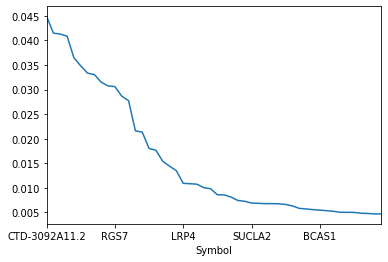

In [203]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

X = df_200F.drop("class",1)
y = df["class"]          #Target Variable
y1 = df["class"]

model = ExtraTreesClassifier()
model.fit(X,y)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

fi_selected = feat_importances.nlargest(50)

fi_selected.plot()

In [204]:
df_50F_FI = df[pd.DataFrame(fi_selected).T.columns]

df_50F_FT_Norm = dfToNorm(df_50F_FI)
df_50F_FT_Norm.head()

df_50F_FI_Norm = round(dfToNorm(df_50F_FI),2)
df_50F_FI_Norm.head()

Symbol,CTD-3092A11.2,BSCL2,TUBB3,FIG4,TAF9,MIR612,UQCRFS1,SLC39A12,EEF1A2,MT1M,RGS7,PCYOX1L,CD200,EMC4,AX747182,PRR34-AS1,RP11-271C24.3,KIAA1279,LOC202181,SST,LRP4,MGC12488,RP11-710C12.1,PLSCR4,SLC39A10,NIF3L1,MIF,CKMT1A,PPEF1,CRYM,SUCLA2,TUBA4A,SMYD3,CALY,ADCYAP1,ARPC1A,SDR16C5,SCN3B,P2RY14,PCSK1,BCAS1,CHRM1,PSMB3,MKKS,ATP6V0B,NPTX2,PRO1804,GFAP,SLC12A7,NIT2
GSM119615,1.68,1.57,1.62,1.64,1.53,1.27,1.55,1.59,1.38,1.20,1.62,1.60,1.79,1.53,1.42,1.42,1.66,1.62,1.60,1.68,1.44,1.42,1.25,1.75,1.99,1.63,1.52,1.63,1.39,1.75,1.67,1.68,1.59,1.45,1.43,1.39,1.43,1.81,1.10,1.46,1.16,1.43,1.56,1.59,1.57,1.72,1.12,1.50,1.51,1.63
GSM119616,1.45,1.77,1.81,1.80,1.37,1.09,1.44,1.17,1.60,1.26,1.63,1.82,1.76,1.61,1.31,1.48,1.44,1.44,1.50,1.86,1.22,1.41,1.36,1.39,1.67,1.45,1.78,1.73,1.71,1.65,1.59,1.88,1.51,1.53,1.39,1.54,1.40,1.88,1.13,1.26,1.18,1.75,1.79,1.63,1.64,1.47,1.20,1.57,1.46,1.65
GSM119617,1.12,1.46,1.47,1.66,1.13,1.14,1.10,1.16,1.47,1.49,1.50,1.51,1.41,1.23,1.55,1.50,1.30,1.21,1.66,1.31,1.32,1.50,1.10,1.36,1.12,1.18,1.62,1.50,1.35,1.42,1.21,1.26,1.17,1.29,1.18,1.30,1.22,1.64,1.09,1.08,1.22,1.55,1.39,1.13,1.40,1.08,1.22,1.52,1.54,1.10
GSM119618,1.29,1.63,1.55,1.73,1.17,1.18,1.15,1.17,1.58,1.52,1.52,1.55,1.41,1.35,1.56,1.61,1.21,1.28,1.67,1.40,1.29,1.63,1.05,1.39,1.20,1.23,1.76,1.58,1.30,1.46,1.22,1.40,1.21,1.47,1.17,1.20,1.20,1.69,1.17,1.09,1.24,1.69,1.50,1.22,1.47,1.24,1.26,1.58,1.56,1.20
GSM119619,1.53,1.86,1.87,1.75,1.73,1.20,1.75,1.44,1.55,1.34,1.83,1.69,1.82,1.80,1.18,1.41,1.78,1.73,1.61,1.90,1.39,1.37,1.63,1.63,1.92,1.64,1.70,1.71,1.81,1.82,1.78,1.97,1.85,1.74,1.75,1.62,1.58,1.90,1.11,1.64,1.36,1.60,1.65,1.80,1.86,1.64,1.30,1.46,1.34,1.92


**Correlation Matrix with Heatmap**

In [205]:
import seaborn as sns

# df_all_cols = pd.concat([X_scaled['205738_s_at'],X_scaled['201341_at'],Y], axis = 1)
# df_all_cols = pd.concat([X_scaled.T[0:20].T,Y], axis = 1)
# df_all_cols['!Sample_characteristics_ch1 Disease State bool'] = df_all_cols['!Sample_characteristics_ch1 Disease State bool'].astype(float)
# print(df_all_cols.dtypes)

#get correlations of each features in dataset
corrmat = df_50F_FI.corr()
# sns.heatmap(corr)
top_corr_features = corrmat.index
plt.figure(figsize=(15,15))

#plot heat map
# g=sns.heatmap(df_50F_FI[top_corr_features].corr(),annot=True,cmap="RdYlGn")

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [0]:
# figure = g.get_figure()    
# figure.savefig('drive/My Drive/FYP/plots/hm_50_rf.png', dpi=400)

In [0]:
from sklearn.model_selection import train_test_split 

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics

from nltk.classify.scikitlearn import SklearnClassifier 
from sklearn.model_selection import cross_val_score, cross_val_predict

Classification accuracy of selected genes

In [0]:
# def featureFI(df,y,i):
#   # X = df.drop("class",1)
#   # y = df["class"]          #Target Variable

#   model = ExtraTreesClassifier()
#   model.fit(df,y)

#   #plot graph of feature importances for better visualization
#   feat_importances = pd.Series(model.feature_importances_, index=df.columns)

#   fi_selected = feat_importances.nlargest(i)

#   df_FI = df[pd.DataFrame(fi_selected).T.columns]
#   # df_FI["class"] = y
#   # print(df_FI.shape)
#   return df_FI

# def featureRF(df,y,i):
#   model = RandomForestClassifier(n_estimators=10000, random_state=42, n_jobs=-1)
#   model.fit(df,y)

#   #plot graph of feature importances for better visualization
#   feat_importances = pd.Series(model.feature_importances_, index=df.columns)

#   rf_selected = feat_importances.nlargest(i)

#   df_FI = df[pd.DataFrame(rf_selected).T.columns]
#   # df_FI["class"] = y

#   return df_FI

# def featurePCA(X,y, i):
#   bestfeatures = SelectKBest(score_func=chi2, k=10)
#   fit = bestfeatures.fit(X,y)
#   dfscores = pd.DataFrame(fit.scores_)
#   dfcolumns = pd.DataFrame(X.columns)

#   #concat two dataframes for better visualization 
#   featureScores = pd.concat([dfcolumns,dfscores],axis=1)
#   featureScores.columns = ['Specs','Score']  #naming the dataframe columns
#   # print(featureScores.nlargest(2000,'Score'))  #print 10 best features
#   selectedFeatures = featureScores.nlargest(200,'Score')

#   pd.options.mode.chained_assignment = None

#   df_200F = X[selectedFeatures['Specs'].values]

#   return df_200F


In [0]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

from sklearn.model_selection import KFold

def svmLinear(dataFrame, target):

  clf = svm.SVC(kernel='linear') # Linear Kernel
  scores = cross_val_score(clf, dataFrame, target, cv=3)

  return scores.mean()

from sklearn.svm import SVC

def svmGaussian(dataFrame, target):

  #Create a svm Classifier
  clf = SVC(kernel="rbf", gamma="auto", C=1)
  scores = cross_val_score(clf, dataFrame, target, cv=3)

  return scores.mean()

from sklearn.ensemble import RandomForestClassifier

def randomForest(dataFrame, target):

  #Create a svm Classifier
  clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=42)
  scores = cross_val_score(clf, dataFrame, target, cv=3)

  return scores.mean()

def returnScoreDataFrame(dataFrame):
  lists1 = []
  lists2 = []
  lists3 = []

  for i in [50, 40, 30, 20, 15, 10, 5, 3, 2 , 1]:

    # if a == 0:
    #   dataFrame = featureFI(dataFrame,y, i)
    # elif a ==1 :
    #   dataFrame = featureRF(dataFrame,y, i)
    # elif a == 2:
    #   dataFrame = featurePCA(dataFrame,y, i)

    lists1.append(svmLinear(dataFrame.iloc[:,0:(i)], y))
    lists2.append(svmGaussian(dataFrame.iloc[:,0:(i)], y))
    lists3.append(randomForest(dataFrame.iloc[:,0:(i)], y))

  rows = ["svmLinear", "svmGaussian", "randomForest"]

  data = np.array([lists1, lists2,lists3])
  randomForestScore = pd.DataFrame(data=data, index=rows).transpose()

  return randomForestScore


In [0]:
randomForestScore = returnScoreDataFrame(df_50F_RF)
featureImpotanceScore = returnScoreDataFrame(df_50F_FI)
pcaScore = returnScoreDataFrame(df_50F_PCA)

In [0]:
listx = []
for i in range(0, 50):
  listx.append(str(50-i))
  
pcaScore['x'] = ["50", "40", "30", "20", "15", "10", "5", "3", "2" , "1"]  
# pcaScore.head()

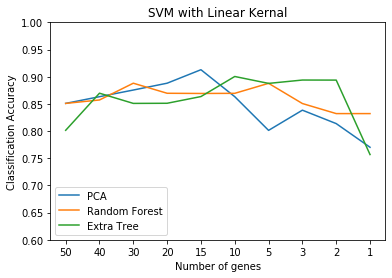

In [246]:
plt.plot(pcaScore['x'], pcaScore["svmLinear"], label='linear')
plt.plot(pcaScore['x'], randomForestScore["svmLinear"], label='linear')
plt.plot(pcaScore['x'], featureImpotanceScore["svmLinear"], label='linear')

plt.ylim(0.6, 1)
# plt.xticks(np.arange(0, 50, 5)) #set(xlim=(0.95,0.80))

plt.legend(['PCA' ,'Random Forest', 'Extra Tree' ], loc='lower left')

plt.xlabel('Number of genes')
plt.ylabel('Classification Accuracy')
plt.title('SVM with Linear Kernal')
# plt.savefig('drive/My Drive/FYP/plots/cSVM_Linear_Kernal.png', dpi=400)
plt.show()

<Figure size 432x288 with 0 Axes>

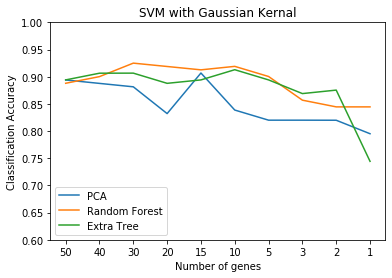

In [247]:
plt.plot(pcaScore['x'], pcaScore["svmGaussian"], label='linear')
plt.plot(pcaScore['x'], randomForestScore["svmGaussian"], label='linear')
plt.plot(pcaScore['x'], featureImpotanceScore["svmGaussian"], label='linear')

plt.ylim(0.6, 1)
# plt.xticks(np.arange(0, 50, 5))

plt.legend(['PCA' ,'Random Forest', 'Extra Tree' ], loc='lower left')

plt.xlabel('Number of genes')
plt.ylabel('Classification Accuracy')
plt.title('SVM with Gaussian Kernal')
# plt.savefig('drive/My Drive/FYP/plots/SVM_Gaussian_Kernal.png', dpi=400)
plt.show()

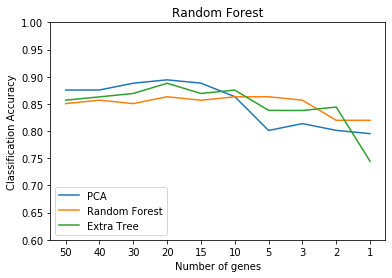

In [248]:
plt.plot(pcaScore['x'], pcaScore["randomForest"], label='linear')
plt.plot(pcaScore['x'], randomForestScore["randomForest"], label='linear')
plt.plot(pcaScore['x'], featureImpotanceScore["randomForest"], label='linear')

plt.ylim(0.6, 1.0)
# plt.xticks(np.arange(0, 50, 5))

plt.legend(['PCA' ,'Random Forest', 'Extra Tree' ], loc='lower left')

plt.xlabel('Number of genes')
plt.ylabel('Classification Accuracy')
plt.title('Random Forest')
# plt.savefig('drive/My Drive/FYP/plots/RandomForest.png', dpi=400)
plt.show()

Mutual information of selected genes

In [215]:
pip install pyitlib

In [0]:
from pyitlib import discrete_random_variable as drv

# drv.entropy_conditional(df_50F_PCA_Norm['SST'], df_50F_PCA_Norm['CHGB'])

In [0]:
# A Python program to print all  
# combinations of given length 
from itertools import combinations 
from sklearn.metrics import normalized_mutual_info_score

# Get all combinations of [1, 2, 3] 
# and length 2 
combPCA = combinations(df_50F_PCA_Norm.columns, 2) 
combFI = combinations(df_50F_FI_Norm.columns, 2)
combRF = combinations(df_50F_RF_Norm.columns, 2)

# Print the obtained combinations 
miValuesPCA = []
miValuesFI = []
miValuesRF = []
for i in (combPCA):   
    valPCA = drv.entropy_conditional(df_50F_PCA_Norm[i[0]], df_50F_PCA_Norm[i[1]],'arithmetic')
    miValuesPCA.append(valPCA)

for i in (combFI):   
    valFI = drv.entropy_conditional(df_50F_FI_Norm[i[0]], df_50F_FI_Norm[i[1]],'arithmetic')
    miValuesFI.append(valFI)

for i in (combRF):   
    valRF = drv.entropy_conditional(df_50F_RF_Norm[i[0]], df_50F_RF_Norm[i[1]],'arithmetic')
    miValuesRF.append(valRF)
    
# print(miValuesPCA)
# print(miValuesFI)
# print(miValuesRF)

In [218]:
print(max(miValuesPCA))
print(min(miValuesPCA))

1.787313265005542
1.1203589841300925


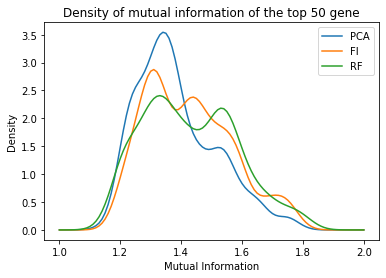

In [219]:
from scipy import stats

kernelPCA = stats.gaussian_kde(miValuesPCA)
kernelFI = stats.gaussian_kde(miValuesFI)
kernelRF = stats.gaussian_kde(miValuesRF)

ind = np.linspace(1,2,101)

kdePCA = kernelPCA.evaluate(ind)
kdeFI = kernelFI.evaluate(ind)
kdeRF = kernelRF.evaluate(ind)

plt.plot(ind, kdePCA, label='PCA')
plt.plot(ind, kdeFI, label='FI')
plt.plot(ind, kdeRF, label='RF')

plt.legend(loc='upper right')

plt.xlabel('Mutual Information')
plt.ylabel('Density')
plt.title('Density of mutual information of the top 50 gene')

plt.show()

In [237]:
print(np.trapz(kdePCA, dx=15),np.trapz(kdeFI, dx=15),np.trapz(kdeRF, dx=15))

1499.9998898916992 1499.9999964494132 1497.5500460352253


In [221]:
print(np.trapz(kdePCA,ind), np.trapz(kdeFI,ind), np.trapz(kdeRF,ind))

0.9999999265944663 0.9999999976329422 0.9983666973568167


Accuracy of six classifiers (200 genes)

In [0]:
def printClassificationResults(X_train, X_test, y_train, y_test):
  import seaborn as sn
    
  # training the model on training set 
  gnb_clf = GaussianNB() 
  score_gnb = cross_val_score(gnb_clf, X_train, y_train, cv=3)
  gnb_clf.fit(X_train, y_train) 

  dt_clf = DecisionTreeClassifier()
  score_dt = cross_val_score(dt_clf, X_train, y_train, cv=3)
  dt_clf.fit(X_train, y_train) 

  knn_clf = KNeighborsClassifier(n_neighbors=2)
  score_knn = cross_val_score(knn_clf, X_train, y_train, cv=3)
  knn_clf.fit(X_train, y_train)

  svm_li_clf = svm.SVC(kernel='linear') # Linear Kernel
  score_svm_li = cross_val_score(svm_li_clf, X_train, y_train, cv=3)
  svm_li_clf.fit(X_train, y_train)

  svm_rbf_clf = SVC(kernel="rbf", gamma="auto", C=1)
  score_svm_rbf = cross_val_score(svm_rbf_clf, X_train, y_train, cv=3)
  svm_rbf_clf.fit(X_train, y_train)

  RF_clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=42)
  score_RF = cross_val_score(RF_clf, X_train, y_train, cv=3)
  RF_clf.fit(X_train, y_train)
    
  # making predictions on the testing set 
  y_pred_gnb = gnb_clf.predict(X_test) 
  y_pred_dt = dt_clf.predict(X_test) 
  y_pred_knn = knn_clf.predict(X_test)
  y_pred_svm_li = svm_li_clf.predict(X_test)
  y_pred_svm_rbf = svm_rbf_clf.predict(X_test)
  y_pred_RF = RF_clf.predict(X_test)

  
  # print(metrics.accuracy_score( cross_val_predict(gnb_clf, X_test, y_test, cv=3) , y_test))

  # making predictions on the training set
  # y_pred_gnb_tr = gnb_clf.predict(X_train) 
  # y_pred_dt_tr = dt_clf.predict(X_train) 
  # y_pred_knn_tr = knn_clf.predict(X_train)
  # y_pred_svm_li_tr = svm_li_clf.predict(X_train)
  # y_pred_svm_rbf_tr = svm_rbf_clf.predict(X_train)

  # ROC curves
  # y_pred_proba_gnb = gnb_clf.predict_proba(X_test)[::,1]
  # fpr_gnb, tpr_gnb, _ = metrics.roc_curve(np.int64(y_test.values),  y_pred_proba_gnb)
  # auc_gnb = metrics.roc_auc_score(np.int64(y_test.values), y_pred_proba_gnb)

  # y_pred_proba_dt = dt_clf.predict_proba(X_test)[::,1]
  # fpr_dt, tpr_dt, _ = metrics.roc_curve(np.int64(y_test.values),  y_pred_proba_dt)
  # auc_dt = metrics.roc_auc_score(np.int64(y_test.values), y_pred_proba_dt)

  # y_pred_proba_knn = knn_clf.predict_proba(X_test)[::,1]
  # fpr_knn, tpr_knn, _ = metrics.roc_curve(np.int64(y_test.values),  y_pred_proba_knn)
  # auc_knn = metrics.roc_auc_score(np.int64(y_test.values), y_pred_proba_knn)
  
  # plt.plot(fpr_gnb,tpr_gnb,label="NB, auc="+str(round(auc_gnb,2)))
  # plt.plot(fpr_dt,tpr_dt,label="DT, auc="+str(round(auc_dt,2)))
  # plt.plot(fpr_knn,tpr_knn,label="KNN, auc="+str(round(auc_knn,2)))
  
  # plt.legend(loc=4)
  # plt.show()
    
  # comparing actual response values (y_test) with predicted response values (y_pred) 
  print("\t\t\t\t\t\t Testing\t Training")
  print("Gaussian Naive Bayes model accuracy(in %) \t:", round(metrics.accuracy_score(np.int64(y_test.values), y_pred_gnb)*100,2) ,"\t", round(score_gnb.mean()*100,2))
  print("Decision Tree model accuracy(in %) \t\t:", round(metrics.accuracy_score(np.int64(y_test.values), y_pred_dt)*100,2) ,"\t", round(score_dt.mean()*100,2))
  print("Nearest Neighbors model accuracy(in %) \t\t:", round(metrics.accuracy_score(np.int64(y_test.values), y_pred_knn)*100,2) ,"\t", round(score_knn.mean()*100,2))
  print("SVM + Gaussian kernel model accuracy(in %) \t:" , round(metrics.accuracy_score(np.int64(y_test.values), y_pred_svm_rbf)*100,2) ,"\t", round(score_svm_rbf.mean()*100,2))
  print("SVM + linear kerne model accuracy(in %) \t:" , round(metrics.accuracy_score(np.int64(y_test.values), y_pred_svm_li)*100,2) ,"\t", round(score_svm_li.mean()*100,2))
  print("Random forest model accuracy(in %) \t \t:" , round(metrics.accuracy_score(np.int64(y_test.values), y_pred_RF)*100,2) ,"\t", round(score_RF.mean()*100,2))


In [0]:
df_Test = pd.read_pickle("drive/My Drive/FYP/dataset/GSE84422/GSE84422_24438_Test_set.plk")
df_Test.head()

df_Test_200 = df_Test[df_200F.columns]

X_Test = df_Test_200.drop("class",1)
y_Test = df_Test_200["class"]

In [224]:
X = df_200F.drop("class",1)
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

printClassificationResults(X_train, X_test, y_train, y_test)

						 Testing	 Training
Gaussian Naive Bayes model accuracy(in %) 	: 81.63 	 83.93
Decision Tree model accuracy(in %) 		: 85.71 	 75.87
Nearest Neighbors model accuracy(in %) 		: 85.71 	 86.58
SVM + Gaussian kernel model accuracy(in %) 	: 83.67 	 91.06
SVM + linear kerne model accuracy(in %) 	: 89.8 	 93.76
Random forest model accuracy(in %) 	 	: 83.67 	 87.48


In [0]:
# Save 200 of feature data frame as plk file
# df_200F.to_pickle("drive/My Drive/FYP/dataset/GSE5281/GSE5281_DE_200.plk")

In [0]:
def printTop3ClassificationResults(X_train, X_test, y_train, y_test): 
  
  m = getTop3ClassificationResults(X_train, X_test, y_train, y_test)

  print("\t\t\t\t\t\t Testing\t Training")
  print("SVM + Gaussian kernel model accuracy(in %) \t:" , m[0][0] ,"\t", m[0][1])
  print("SVM + linear kerne model accuracy(in %) \t:" , m[1][0] ,"\t", m[1][1])
  print("Random forest model accuracy(in %) \t\t:" , m[2][0] ,"\t", m[2][1])


def getTop3ClassificationResults(X_train, X_test, y_train, y_test):
  svm_li_clf = svm.SVC(kernel='linear') # Linear Kernel
  score_svm_li = cross_val_score(svm_li_clf, X_train, y_train, cv=3)
  svm_li_clf.fit(X_train, y_train)

  svm_rbf_clf = SVC(kernel="rbf", gamma="auto", C=1)
  score_svm_rbf = cross_val_score(svm_rbf_clf, X_train, y_train, cv=3)
  svm_rbf_clf.fit(X_train, y_train)
  
  RF_clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=42)
  score_RF = cross_val_score(RF_clf, X_train, y_train, cv=3)
  RF_clf.fit(X_train, y_train)

  y_pred_svm_li = svm_li_clf.predict(X_test)
  y_pred_svm_rbf = svm_rbf_clf.predict(X_test)
  y_pred_RF = RF_clf.predict(X_test)

  m = np.array([[round(metrics.accuracy_score(np.int64(y_test.values), y_pred_svm_rbf)*100,2) , round(score_svm_rbf.mean()*100,2)], 
                [round(metrics.accuracy_score(np.int64(y_test.values), y_pred_svm_li)*100,2) , round(score_svm_li.mean()*100,2)],
                [round(metrics.accuracy_score(np.int64(y_test.values), y_pred_RF)*100,2) , round(score_svm_li.mean()*100,2)]])
  
  return m


In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

def getROC(X_train, X_test, y_train, y_test):

  classifier_SVM_li = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                  random_state=42))
  classifier_SVM_gu = OneVsRestClassifier(svm.SVC(kernel='rbf', probability=True,
                                  random_state=42))
  classifier_RF = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=42)

  y_score_SVM_li = classifier_SVM_li.fit(X_train, y_train).decision_function(X_test)
  y_score_SVM_gu = classifier_SVM_gu.fit(X_train, y_train).decision_function(X_test)
  y_score_SVM_RF = classifier_RF.fit(X_train, y_train)

  fpr_li, tpr_li, _ = roc_curve(np.int64(y_test.ravel()), y_score_SVM_li.ravel())
  fpr_gu, tpr_gu, _ = roc_curve(np.int64(y_test.ravel()), y_score_SVM_gu.ravel())

  roc_auc_li = auc(fpr_li, tpr_li)
  roc_auc_gu = auc(fpr_gu, tpr_gu)

  y_pred_proba_RF = classifier_RF.predict_proba(X_test)[::,1]
  fpr_RF, tpr_RF, _ = metrics.roc_curve(np.int64(y_test.values),  y_pred_proba_RF)
  roc_auc_RF = metrics.roc_auc_score(np.int64(y_test.values), y_pred_proba_RF)

  plt.plot(fpr_li,tpr_li,label="SVM linear, auc="+str(round(roc_auc_li,2)))
  plt.plot(fpr_gu,tpr_gu,label="SVM gaussian, auc="+str(round(roc_auc_gu,2)))
  plt.plot(fpr_RF,tpr_RF,label="SVM gaussian, auc="+str(round(roc_auc_RF,2)))

  plt.legend(loc="lower right")

PCA accuracy

						 Testing	 Training
SVM + Gaussian kernel model accuracy(in %) 	: 87.76 	 90.16
SVM + linear kerne model accuracy(in %) 	: 85.71 	 88.41
Random forest model accuracy(in %) 		: 85.71 	 88.41


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


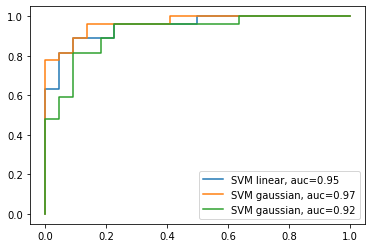

In [228]:
df_Test_PCA = df_Test[df_50F_PCA.columns]

X_Test = df_Test_PCA
y_Test = df_Test["class"]

X_train, X_test, y_train, y_test = train_test_split(df_50F_PCA, y, test_size=0.3, random_state=42) 

printTop3ClassificationResults(X_train, X_test, y_train, y_test) #same dataset
getROC(X_train, X_test, y_train, y_test)

FI accuracy

						 Testing	 Training
SVM + Gaussian kernel model accuracy(in %) 	: 91.84 	 90.16
SVM + linear kerne model accuracy(in %) 	: 85.71 	 90.14
Random forest model accuracy(in %) 		: 85.71 	 90.14


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


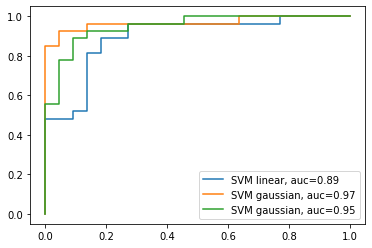

In [229]:
df_Test_FI = df_Test[df_50F_FI.columns]

X_Test = df_Test_FI
y_Test = df_Test["class"]

X_train, X_test, y_train, y_test = train_test_split(df_50F_FI, y, test_size=0.3, random_state=42) 

printTop3ClassificationResults(X_train, X_test, y_train, y_test) #same dataset
getROC(X_train, X_test, y_train, y_test)

RF acurray

						 Testing	 Training
SVM + Gaussian kernel model accuracy(in %) 	: 87.76 	 89.26
SVM + linear kerne model accuracy(in %) 	: 91.84 	 91.94
Random forest model accuracy(in %) 		: 83.67 	 91.94


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


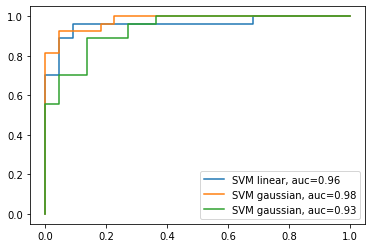

In [230]:
df_Test_RF = df_Test[df_50F_RF.columns]

X_Test = df_Test_RF
y_Test = df_Test["class"]

X_train, X_test, y_train, y_test = train_test_split(df_50F_RF, y, test_size=0.3, random_state=42) 

printTop3ClassificationResults(X_train, X_test, y_train, y_test) #same dataset
getROC(X_train, X_test, y_train, y_test)

In [0]:
def saveFoundSymbols(df, name):
  tmp_df = pd.DataFrame( df.columns)
  # tmp_df.head()
  tmp_df.to_pickle("drive/My Drive/FYP/Found genes/" + name +".pkl")

# saveFoundSymbols(df_50F_FI,"brain_50_FI")
# saveFoundSymbols(df_50F_PCA,"brain_50_PCA")
# saveFoundSymbols(df_50F_RF,"brain_50_RF")
# saveFoundSymbols(df_200F,"brain_200_")

In [0]:
def getSummaryFeatureSelection(df_50F_PCA, df_50F_FI, df_50F_RF):

  X_train, X_test, y_train, y_test = train_test_split(df_50F_PCA, y, test_size=0.3, random_state=42) 
  m_pca = getTop3ClassificationResults(X_train, X_test, y_train, y_test)

  X_train, X_test, y_train, y_test = train_test_split(df_50F_FI, y, test_size=0.3, random_state=42) 
  m_fi = getTop3ClassificationResults(X_train, X_test, y_train, y_test)

  X_train, X_test, y_train, y_test = train_test_split(df_50F_RF, y, test_size=0.3, random_state=42) 
  m_rf = getTop3ClassificationResults(X_train, X_test, y_train, y_test)

  rows = ["classifier","PCA", "Random Forest", "Extra Tree"]
  cla = ["SVM + Gaussian kernel", "SVM + linear kerne", "Random forest"]

  data_testing = np.array([cla, m_pca[:,0], m_fi[:,0], m_rf[:,0]])
  results_testing = pd.DataFrame(data=data_testing, index=rows).transpose()

  data_training = np.array([cla, m_pca[:,1], m_fi[:,1], m_rf[:,1]])
  results_training = pd.DataFrame(data=data_training, index=rows).transpose()

  results_testing = results_testing.set_index('classifier')
  results_training = results_training.set_index('classifier')

  results_testing = results_testing.astype(float)
  results_training = results_training.astype(float)

  return results_testing, results_training

In [0]:
results_testing, results_training = getSummaryFeatureSelection(df_50F_PCA, df_50F_FI, df_50F_RF)

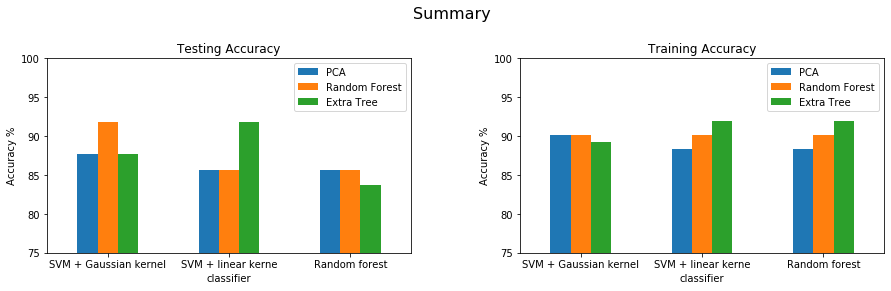

In [234]:
fig, axes = plt.subplots(nrows=1, ncols=2)

fig.subplots_adjust(wspace=0.3, hspace=0.2, top=0.8)
fig.set_figwidth(15)

axes[0].set_ylim([75,100])
axes[1].set_ylim([75,100])
axes[0].set_ylabel("Accuracy %")
axes[1].set_ylabel("Accuracy %")
axes[0].set_title("Testing Accuracy")
axes[1].set_title("Training Accuracy")

fig.suptitle('Summary', fontsize=16)

results_testing.plot.bar(rot=0, ax=axes[0])
results_training.plot.bar(rot=0, ax=axes[1])

fig.savefig('drive/My Drive/FYP/plots/summary_50.png', dpi=400)

In [0]:
Y=[2,1,2,2,1,1,1,2,1,1,2,2]
Z=[2,1,2,2,1,1,1,2,1,1,2,2]

In [236]:
drv.entropy_conditional(Y, Z,'arithmetic')

array(0.)